# Principal Component Analysis

### Authors

| Name | Roll Number |
|-|-|
| Gautam Singh | CS21BTECH11018 |
| Jaswanth Beere | BM21BTECH11007 |

This `.ipynb` notebook performs Principal Component Analysis (PCA) on the SVHN
dataset.

## Obtaining the Data

The SVHN dataset is obtained using the `curl` command on the appropriate file
URL.

In [1]:
%%bash

if [ ! -f train_32x32.mat ]; then
    curl -O http://ufldl.stanford.edu/housenumbers/train_32x32.mat
fi

In [2]:
%%bash

if [ ! -f test_32x32.mat ]
then
    curl -O http://ufldl.stanford.edu/housenumbers/test_32x32.mat
fi

## Package Imports

For this exercise, the following packages must be installed and imported.

In [3]:
%pip install numpy scikit-learn scipy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import io
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

## Data Visualization

We begin by visualizing part of the raw data. First, we must load the data into
`numpy` arrays for processing.

In [5]:
# Load training and test data

train_data = io.loadmat('train_32x32.mat')
test_data = io.loadmat('test_32x32.mat')

# Separate training data inputs (images) and outputs (classes)

train_X = train_data['X']
train_Y = train_data['y']
test_X = test_data['X']
test_Y = test_data['y']

NUM_TRAIN_SAMPLES = train_X.shape[-1]
NUM_TEST_SAMPLES = test_X.shape[-1]

Next, we reshape the dimensions of `train_X` such that the first index
represents sample number. Further, we scale all features to zero mean and unit
variance.

In [6]:
# Reshape train_X such that train_X[i] is the ith image in the dataset
# Further, flatten image arrays for PCA.

train_X_reshaped = train_X.reshape(32*32*3, NUM_TRAIN_SAMPLES).T
test_X_reshaped = test_X.reshape(32*32*3, NUM_TEST_SAMPLES).T
train_Y_reshaped = train_Y.ravel()
test_Y_reshaped = test_Y.ravel()

## Sampling the Data

To perform PCA on the given dataset, we sample 2500 data points of each digit
from 0 to 9, giving us 25000 training examples to perform PCA on. Note that 0 is
represented as 10 in the dataset.

In [7]:
# Sample 2500 training examples for each digit
NUM_SAMPLES_PER_CLASS = 2500

# Use a numpy random number generator
rng = np.random.default_rng()

# Array of randomly chosen indices
ind_arr = np.array([])

for i in range(1,11,1):
    # Find the indices in the training set corresponding to digit
    idx = np.where(train_Y == i)[0]
    # Generate samples randomly
    rand_samples = rng.choice(idx, NUM_SAMPLES_PER_CLASS, False)
    # Append to index array
    ind_arr = np.append(ind_arr, rand_samples)

ind_arr = np.asarray(ind_arr, int)
# Finally, generate random samples and their labels
train_X_gen = train_X_reshaped[ind_arr]
train_Y_gen = train_Y[ind_arr]

We are now in a position to perform PCA on our training set and visualize how
the proportion of variance (PoV) changes with the number of top eigenvectors
considered. But first, we need to normalize our data to zero mean and unit
variance.

In [8]:
# Initialize a scaler object for both training and testing
train_scaler = StandardScaler()
train_scaler.fit(train_X_gen)
train_X_gen_scaled = train_scaler.transform(train_X_gen)

test_scaler = StandardScaler()
test_scaler.fit(test_X_reshaped)
test_X_reshaped_scaled = test_scaler.transform(test_X_reshaped)

# Perform PCA of the generated training set using only the top 10 eigenvectors
pca = PCA(n_components=10)
train_X_pca = pca.fit_transform(train_X_gen_scaled)

# Perform PCA transform of the test data
test_X_pca = pca.transform(test_X_reshaped_scaled)

Here, we visualize the top 10 eigenvectors and their eigenvalues. Then, we
provide a reconstrcution of a sample from each class using these top 10
eigenvectors.

In [9]:
# Number of PCA components
n_components = pca.n_components_
# Visualize top 10 eigenvectors and eigenvalues
print(pca.components_)
print(pca.singular_values_)

[[ 0.01733331  0.01764644  0.01842139 ...  0.01652524  0.01684393
   0.01787479]
 [-0.00600275 -0.0025061   0.00527238 ... -0.02755911 -0.02601118
  -0.01782761]
 [-0.02619233 -0.02510715 -0.01769271 ...  0.00613466  0.00987813
   0.01635929]
 ...
 [ 0.01147155  0.01133878  0.00610335 ... -0.03007386 -0.03050468
  -0.02448567]
 [ 0.01077065  0.0119041   0.00935133 ...  0.02565903  0.02721545
   0.02550871]
 [-0.0113141  -0.01180135 -0.01111579 ...  0.0114733   0.01201995
   0.01223948]]
[6642.70952416 2137.48175046 1986.41991362 1725.09712774 1317.28668399
 1186.05784338 1105.44065854 1060.37402262  986.32726556  926.72112794]


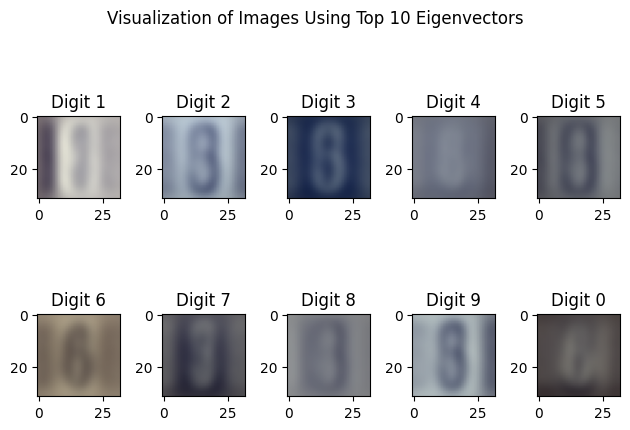

In [10]:
# Visualize the reconstructed samples
fig = plt.figure()
# Note that each class has a starting index of 2500*i
for i in range(10):
    # Add subplot
    sub = fig.add_subplot(2,5,i+1)
    # Perform inverse pca transform and scale
    sub.imshow(np.asarray(train_scaler.inverse_transform(pca.inverse_transform(np.array([train_X_pca[NUM_SAMPLES_PER_CLASS*i]]))), int).reshape(32,32,3))
    sub.title.set_text('Digit ' + str((i+1)%10))

fig.suptitle('Visualization of Images Using Top 10 Eigenvectors')
plt.tight_layout()

Clearly, the images are not reconstructed clearly, as very few (10) eigenvectors
are used compared to the dimension (3072) of the images in the PCA.

## PoV Against the Number of Eigenvectors

To find the ideal number of eigenvectors to use in the PCA, we plot the
Proportion of Variance (PoV) as a function of the number of eigenvectors
considered. We set our threshold PoV to be 0.9 _i.e._, a 90% reconstruction of
the image is ideal.

In [11]:
# Perform PCA with ALL dimensions. This can take a while.
full_pca = PCA()
train_X_allpca = full_pca.fit(train_X_gen_scaled)

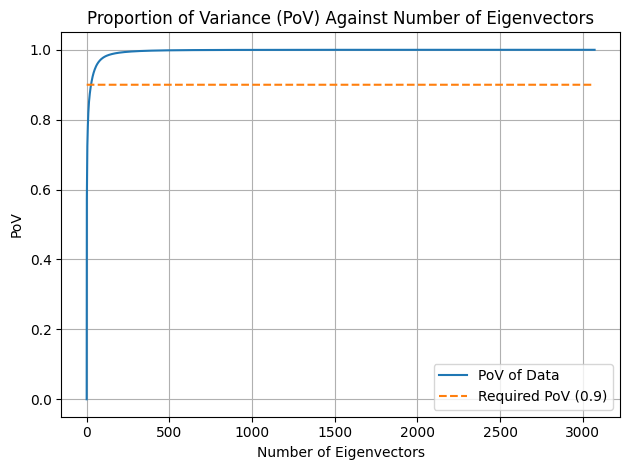

In [12]:
# PoV array (zero padded at the start)
cumulative_variance = np.zeros(len(full_pca.explained_variance_ratio_) + 1)
cumulative_variance[1:] = np.cumsum(full_pca.explained_variance_ratio_)

# Plot the cumulative variance as well as cutoff 0.9 PoV
plt.plot(cumulative_variance)
plt.plot(np.arange(cumulative_variance.shape[0]), 0.9*np.ones_like(cumulative_variance), '--')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('PoV')
plt.title('Proportion of Variance (PoV) Against Number of Eigenvectors')
plt.legend(['PoV of Data', 'Required PoV (0.9)'])
plt.grid()
plt.tight_layout()
plt.show()

From the above figure, it is quite evident that the top 10 eigenvectors will be
insufficient. To find the ideal number of eigenvectors, we can perform binary
search on the `cumulative_variance` array.

In [13]:
pca_comp = np.searchsorted(cumulative_variance, 0.9)
pca_comp

27

It turns out that the ideal number of components needed for the PCA is 27.

## k-NN and PCA

Now, we perform the k-nearest neighbours classification algorithm on the
training dataset, with and without PCA. We also demonstrate the difference in
test accuracy on using different number of eigenvectors for the PCA as found in
the previous sections. Here, we consider `k = 5, 7`.

In [14]:
# Define kNN classifier objects
neigh_five = KNeighborsClassifier(n_neighbors=5)
neigh_seven = KNeighborsClassifier(n_neighbors=7)

### k-NN on Raw Data

The raw data obtained is directly run with kNN, and the accuracies are reported
below.

In [15]:
# Run kNN with k=5 and k=7. This might take a while.

# Using k=5
neigh_five = neigh_five.fit(train_X_gen, train_Y_gen.ravel())
neigh_five_score_raw = neigh_five.score(test_X_reshaped, test_Y_reshaped)
# Using k=7
neigh_seven = neigh_seven.fit(train_X_gen, train_Y_gen.ravel())
neigh_seven_score_raw = neigh_seven.score(test_X_reshaped, test_Y_reshaped)
# Report accuracy
print('Accuracy for raw data using k = 5:', neigh_five_score_raw)
print('Accuracy for raw data using k = 7:', neigh_seven_score_raw)

Accuracy for raw data using k = 5: 0.4034265519360787
Accuracy for raw data using k = 7: 0.41637215734480637


### k-NN on PCA Preprocessed Data

To improve the accuracy (which is about 41.86%) of kNN, we perform it on the
preprocessed data.

#### Using 10 Eigenvectors

In [16]:
# Run kNN with k=5 and k=7. This might take a while.

# Using k=5
neigh_five = neigh_five.fit(train_X_pca, train_Y_gen.ravel())
neigh_five_score_raw = neigh_five.score(test_X_pca, test_Y_reshaped)
# Using k=7
neigh_seven = neigh_seven.fit(train_X_pca, train_Y_gen.ravel())
neigh_seven_score_raw = neigh_seven.score(test_X_pca, test_Y_reshaped)
# Report accuracy
print('Accuracy for raw data using k = 5:', neigh_five_score_raw)
print('Accuracy for raw data using k = 7:', neigh_seven_score_raw)

Accuracy for raw data using k = 5: 0.2588352796558082
Accuracy for raw data using k = 7: 0.2650968039336202


#### Using PoV = 0.9

We have already seen that the 27 top eigenvectors are enough to achieve at least
0.9 proportion of variance. Thus, we require to run PCA with 27 components and
then run kNN.

In [17]:
# Perform PCA with 27 eigenvectors

pca_pov = PCA(n_components=pca_comp)
# Transform the training set to new PCA basis
pca_pov.fit(train_X_gen_scaled)
train_X_pca_pov = pca_pov.transform(train_X_gen_scaled)
test_X_pca_pov = pca_pov.transform(test_X_reshaped_scaled)

In [18]:
# Run kNN with k=5 and k=7. This might take a while.

# Using k=5
neigh_five = neigh_five.fit(train_X_pca_pov, train_Y_gen.ravel())
neigh_five_score_raw = neigh_five.score(test_X_pca_pov, test_Y_reshaped)
# Using k=7
neigh_seven = neigh_seven.fit(train_X_pca_pov, train_Y_gen.ravel())
neigh_seven_score_raw = neigh_seven.score(test_X_pca_pov, test_Y_reshaped)
# Report accuracy
print('Accuracy for raw data using k = 5:', neigh_five_score_raw)
print('Accuracy for raw data using k = 7:', neigh_seven_score_raw)

Accuracy for raw data using k = 5: 0.4132221880762139
Accuracy for raw data using k = 7: 0.42328672403196066


## Observations

From the above results, we can make the following observations.

1. Most of the variance of each dataset lies in very few dimensions (27 compared
   to 3072). Thus, PCA can be used to great effect.
2. Using PCA with only 10 components leads to worse accuracy than using raw
   data. This is because the proportion of variance explained by the top 10
   eigenvectors is not enough for accurate predictions.
3. However, using PCA with 27 components leads to accuracy close enough to the
   raw data without PCA. This is because the PoV threshold chosen is high enough
   to not affect the test error much.
4. Running kNN on the raw data results in the best accuracy as no information is
   lost through dimensionality reduction. However, the improvement in accuracy
   is quite negligible when compared to using only a few eigenvectors. 
5. The gain in runtime by using PCA (for both kNN and PCA algorithms) with the
   appropriate PoV threshold is enough to offset the slight, almost negligible
   loss in accuracy (6.3s compared to 4m 19.7s).